In [1]:
import os

# check if in kaggle 
if 'KAGGLE_CONTAINER_NAME' in os.environ:
    kaggle = True
    os.system('git clone https://github.com/lorenzo-saccaro/NNDL-recoloring-GAN')
    os.chdir('/kaggle/working/NNDL-recoloring-GAN')
    print(os.getcwd())
    # pull repo to update .py files
    os.system('git pull')
    # install needed packages
    os.system('pip install torchview')
    os.system('pip install torchinfo')
    os.system('pip install scikit-image')
    
else:
    kaggle = False
    

In [2]:
from dataset import CocoDataset
from train import Trainer
from models import Generator, Discriminator
from losses import GeneratorCriterion, DiscriminatorCriterion
from utils import remove_grayscale_images
from torchvision.transforms import Compose, Resize
from torch.utils.data import DataLoader
import torch
from torchinfo import summary
from torchview import draw_graph
import matplotlib.pyplot as plt


In [3]:
## RUN PARAMETERS ##

if kaggle:
    DATASET_ROOT = '/kaggle/input/coco-2017-dataset/coco2017'
else:
    DATASET_ROOT = 'C:\\Users\\loren\\Datasets\\coco2017'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32 # TODO: to be tuned (in paper, 1 to 10 range)
NUM_WORKERS = 2 if kaggle else 4

IMG_SIZE = 256
USE_LAB_COLORSPACE = True # whether to use LAB color space
USE_L1_LOSS = True # generator L1 loss
L1_LAMBDA = 100 # li loss coefficient
WGAN = False # whether to use Wasserstein loss
WGAN_GP = False # whether to use Wasserstein loss with gradient penalty
N_CRITIC = 1 if (not WGAN or WGAN_GP) else 5 # number of iteration of critic training
CLIP_WEIGHTS = WGAN and not WGAN_GP # whether to clip critic weights when using Wasserstein loss
CLIP_VALUE = 0.01 # max abs value for critic weights

USE_INSTANCE_NORM = True if BATCH_SIZE==1 else False # norm layer type in models
GEN_IN_CHANNEL = 1 # always 1 channel for grayscale imgs
GEN_OUT_CHANNEL = 2 if USE_LAB_COLORSPACE else 3 # reconstruct only ab channels for Lab images,
DISC_IN_CHANNEL = GEN_IN_CHANNEL + GEN_OUT_CHANNEL # discriminator take both input and output images

# options for Trainer object
options = {
    'checkpoint_path': './test.tar', # checkpoint file
    'use_lab_colorspace' : USE_LAB_COLORSPACE,
    'reset_training': False, # whether to reset or resuming training
    'num_epochs': 100,
    'clip_weights': CLIP_WEIGHTS,
    'clip_value': CLIP_VALUE,
    'n_critic': N_CRITIC,
    'output_path': './imgs', # where to store generated images
    'plot_every_nstep': 30_000//BATCH_SIZE
}

In [4]:
# TODO: SET ALL KIND OF SEEDS FOR REPRODUCIBLE RESULTS

In [5]:
## PREPROCESS: REMOVE GRAYSCALE IMAGES FROM TRAINING DATASET IF PRESENT

remove_grayscale_images(dataset_folder=DATASET_ROOT, dataset_type='train')


# Dataset creation

## Define transformations to apply to each dataset input and output

In [6]:
# TODO: think about other transformation / data augmentation techniques
# No need to include ToTensor, already applied in dataset
transforms_train = Compose([Resize((IMG_SIZE, IMG_SIZE))])

# no data augmentation for val and test
transforms_val = Compose([Resize((IMG_SIZE, IMG_SIZE))])
transforms_test = Compose([Resize((IMG_SIZE, IMG_SIZE))])

## Get dataset objects from helper function

In [7]:
train_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='train', transforms=transforms_train,
                            frac=0.2, use_lab_colorspace=USE_LAB_COLORSPACE)

val_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='val', transforms=transforms_val,
                          frac=1, use_lab_colorspace=USE_LAB_COLORSPACE)

test_dataset = CocoDataset(dataset_folder=DATASET_ROOT, dataset_type='test', transforms=transforms_test,
                           frac=1, use_lab_colorspace=USE_LAB_COLORSPACE)


## Define corresponding dataloaders

In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                              pin_memory=True, persistent_workers=True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                            pin_memory=True, persistent_workers=True)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                             pin_memory=True, persistent_workers=True)


# Models Definition

### Generator

In [9]:
generator = Generator(use_instance_norm=USE_INSTANCE_NORM, in_channels=GEN_IN_CHANNEL, out_channels=GEN_OUT_CHANNEL)
generator.to(device)
print(summary(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=4))


Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [32, 2, 256, 256]         --
├─ModuleList: 1-1                             --                        --
│    └─EncoderBlock: 2-1                      [32, 64, 128, 128]        --
│    │    └─Sequential: 3-1                   [32, 64, 128, 128]        --
│    │    │    └─Conv2d: 4-1                  [32, 64, 128, 128]        1,024
│    │    │    └─LeakyReLU: 4-2               [32, 64, 128, 128]        --
│    └─EncoderBlock: 2-2                      [32, 128, 64, 64]         --
│    │    └─Sequential: 3-2                   [32, 128, 64, 64]         --
│    │    │    └─Conv2d: 4-3                  [32, 128, 64, 64]         131,072
│    │    │    └─BatchNorm2d: 4-4             [32, 128, 64, 64]         256
│    │    │    └─LeakyReLU: 4-5               [32, 128, 64, 64]         --
│    └─EncoderBlock: 2-3                      [32, 256, 32, 32]         --
│    │    └

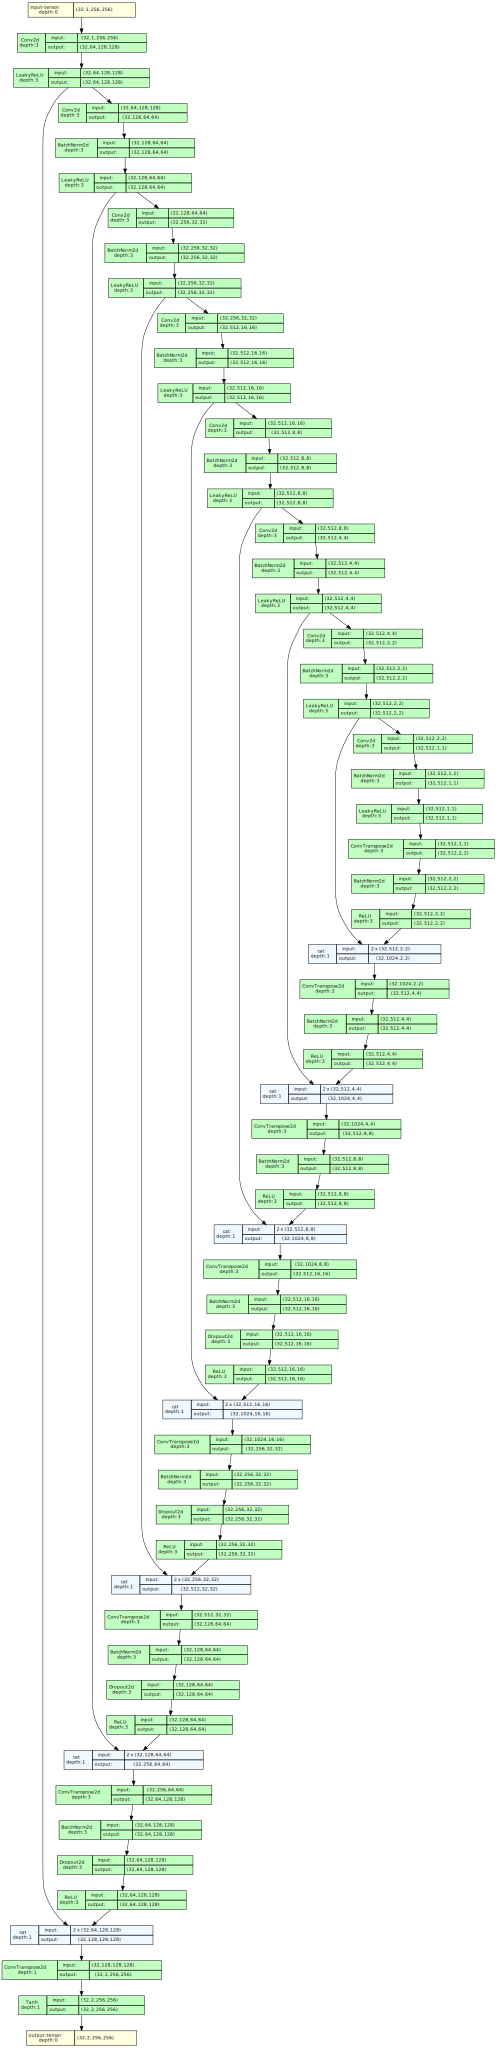

In [10]:
generator_graph = draw_graph(generator, input_size=(BATCH_SIZE, GEN_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
generator_graph.visual_graph

## Discriminator

In [11]:
discriminator = Discriminator(use_instance_norm=USE_INSTANCE_NORM, in_channels=DISC_IN_CHANNEL)
discriminator.to(device)
print(summary(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE), depth=4))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1, 30, 30]           --
├─ModuleList: 1-1                        --                        --
│    └─EncoderBlock: 2-1                 [32, 64, 128, 128]        --
│    │    └─Sequential: 3-1              [32, 64, 128, 128]        --
│    │    │    └─Conv2d: 4-1             [32, 64, 128, 128]        3,072
│    │    │    └─LeakyReLU: 4-2          [32, 64, 128, 128]        --
│    └─EncoderBlock: 2-2                 [32, 128, 64, 64]         --
│    │    └─Sequential: 3-2              [32, 128, 64, 64]         --
│    │    │    └─Conv2d: 4-3             [32, 128, 64, 64]         131,072
│    │    │    └─BatchNorm2d: 4-4        [32, 128, 64, 64]         256
│    │    │    └─LeakyReLU: 4-5          [32, 128, 64, 64]         --
│    └─EncoderBlock: 2-3                 [32, 256, 32, 32]         --
│    │    └─Sequential: 3-3              [32, 256, 32, 32]         --
│    │

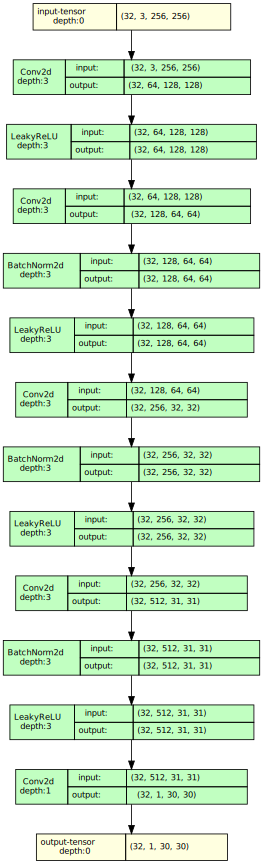

In [12]:
discriminator_graph = draw_graph(discriminator, input_size=(BATCH_SIZE, DISC_IN_CHANNEL, IMG_SIZE, IMG_SIZE))
discriminator_graph.visual_graph

## Define Losses

In [13]:
disc_criterion = DiscriminatorCriterion(device=device, wgan=WGAN, wgan_gp=WGAN_GP)

In [14]:
gen_criterion = GeneratorCriterion(device=device, use_l1_loss=USE_L1_LOSS, l1_lambda=L1_LAMBDA, wgan=WGAN)

## Define Optimizers

In [15]:
if WGAN and not WGAN_GP: # wgan with clipping
    gen_opt = torch.optim.RMSprop(generator.parameters(), lr=5e-5)
    disc_opt = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
else: # gan or wgan gp
    gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training

In [16]:
trainer = Trainer(generator=generator, discriminator=discriminator,
                  gen_optimizer=gen_opt, disc_optimizer=disc_opt,
                  gen_scheduler=None, disc_scheduler=None,
                  gen_criterion=gen_criterion, disc_criterion=disc_criterion,
                  train_loader=train_dataloader, val_loader=val_dataloader,
                  device=device, options=options)


Loading checkpoint from ./test.tar
Generator loaded
Discriminator loaded
Generator optimizer loaded
Discriminator optimizer loaded


In [17]:
trainer.train()

Saving checkpoint to ./test.tar
Checkpoint saved



Epoch 31/100
Training...


Gen loss: 13.4696, Disc loss: 0.0489:   6%|▌         | 44/738 [00:19<05:05,  2.27it/s]


KeyboardInterrupt: 

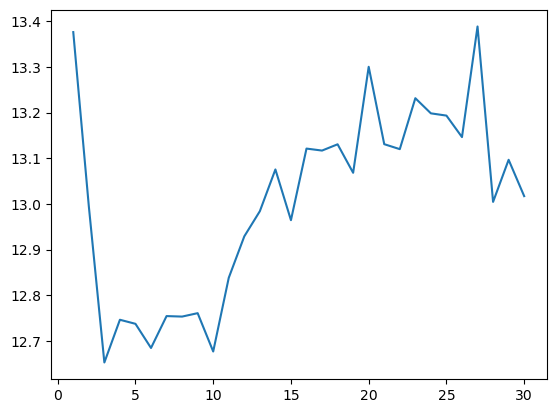

In [18]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_gen_loss'])

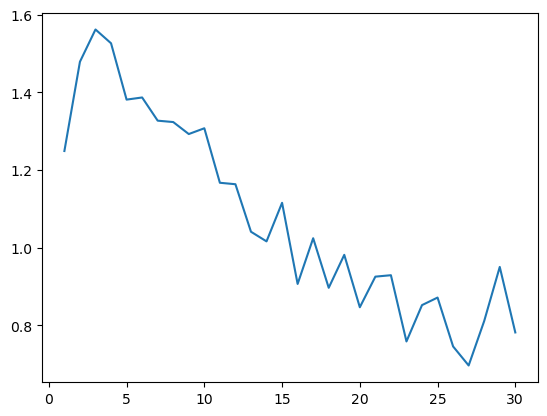

In [19]:
plt.plot(range(1, 1+trainer.history['elapsed_epochs']), trainer.history['train_disc_loss'])